# VGG
based on https://www.kaggle.com/code/kmader/full-vgg-with-torch-example/notebook

In [1]:
%matplotlib inline
import os
import sys
import cv2
import numpy as np
import torch
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn as nn
from torchvision import datasets, transforms
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

## Parameters
Try to keep the model parameters and configurations all in one cell to make it easier to keep track of (and automate later)

In [2]:
IS_TEST = True # to try on very small subset (just 3 groups) 
TEST_SPLIT = 0.25
epochs = 10
batch_size = 64
SAMPLE_TRAINING = False # make train set smaller for faster iteration
IMG_SIZE = (224, 224)
LEARNING_RATE = 4e-3
use_gpu = True

In [3]:
device = torch.device("cuda" if use_gpu else "cpu")
torch.manual_seed(42) # try and make the results more reproducible
BASE_PATH = os.path.join('data')

## Create Dataset
Here we find all of the files and organize them into categories

In [4]:
os.path.join(BASE_PATH, 'images', '*', '*.jpg')

all_img_df = pd.DataFrame({'path':
                           glob(os.path.join(BASE_PATH, 'images', '*', '*.jpg'))})
all_img_df['category'] = all_img_df['path'].map(lambda x: 
                                                os.path.split(os.path.dirname(x))[-1].replace('_', ' '))
if IS_TEST:
    all_img_df = all_img_df[all_img_df['category'].isin(['samosa', 'gnocchi', 'hot dog'])]
    print('test sample only!!!')
    
    
print(all_img_df.category.unique())

test sample only!!!
['gnocchi' 'hot dog' 'samosa']


In [5]:
from sklearn.preprocessing import LabelEncoder
cat_enc = LabelEncoder()
all_img_df['cat_idx'] = cat_enc.fit_transform(all_img_df['category'])
# all_img_df.head
N_CLASSES = len(cat_enc.classes_)
print(N_CLASSES, 'classes')
all_img_df.sample(5)

3 classes


,path,category,cat_idx
55772,data\images\hot_dog\415744.jpg,hot dog,1
47110,data\images\gnocchi\1393831.jpg,gnocchi,0
85081,data\images\samosa\1304601.jpg,samosa,2
55824,data\images\hot_dog\547312.jpg,hot dog,1
47420,data\images\gnocchi\2653951.jpg,gnocchi,0


# Data Loading Classes
Here are the classes to load the data

In [6]:
class DataWrapper(data.Dataset):
    ''' Data wrapper for pytorch's data loader function '''
    def __init__(self, image_df, resize):
        self.dataset = image_df
        self.resize = resize

    def __getitem__(self, index):
        c_row = self.dataset.iloc[index]
        image_path, target = c_row['path'], c_row['cat_idx']  #image and target
        #read as rgb image, resize and convert to range 0 to 1
        image = cv2.imread(image_path, 1)
        if self.resize:
            image = cv2.resize(image, IMG_SIZE)/255.0 
        else:
            image = image/255.0
        image = (torch.from_numpy(image.transpose(2,0,1))).float() #NxCxHxW
        return image, int(target)

    def __len__(self):
        return self.dataset.shape[0] 

## Split data into a train/test group
We can also shrink the size of the training group to make it quicker

In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(all_img_df, 
                                     test_size=TEST_SPLIT, 
                                     random_state=42,
                                     stratify=all_img_df['category'])

if SAMPLE_TRAINING: # make train smaller for faster testing
    train_df = train_df.\
        groupby('category').\
        apply(lambda x: x.sample(50)).\
        reset_index(drop=True).\
        sample(frac=1).\
        reset_index(drop=True)
print('train', train_df.shape[0], 'test', test_df.shape[0])

train 2250 test 750


In [8]:
train_dataset = DataWrapper(train_df, True)
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True, 
            batch_size=batch_size, pin_memory=False)#, num_workers=4)

test_dataset = DataWrapper(test_df, True)
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True, 
            batch_size=batch_size, pin_memory=False) #num_workers=1)

# Build the VGG Model

In [9]:
class ConvBnReLu(nn.Module):
    '''Repetitive block of conv->batch norm->relu'''
    def __init__(self,in_planes,out_planes,drop=0.0,kernel=3,padding=1,stride=1):
        super(ConvBnReLu, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=3, 
                                          stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=drop)

    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        return self.drop(self.relu(x))
    

def conv3x3(in_planes, out_planes, stride=1):
    '''Simple 3x3 convolution'''
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, 
                              stride=stride, padding=1)

class VGGNet(nn.Module):
    def __init__(self,num_feat=16,num_class=N_CLASSES):
        """Define the components of a VGG 11 model"""
        super(VGGNet, self).__init__()     
        self.num_feat = num_feat
        self.conv_1 = conv3x3(3,num_feat)
        self.conv_2 = conv3x3(num_feat,2*num_feat)
        self.conv_3_1 = conv3x3(2*num_feat,4*num_feat)
        self.conv_3_2 = conv3x3(4*num_feat,4*num_feat)
        self.conv_4_1 = conv3x3(4*num_feat,8*num_feat)
        self.conv_4_2 = conv3x3(8*num_feat,8*num_feat)
        self.conv_5_1 = conv3x3(8*num_feat,8*num_feat)
        self.conv_5_2 = conv3x3(8*num_feat,2*num_feat)

        self.fc1 = nn.Linear((2*num_feat)*7*7,512)
        self.fc2 = nn.Linear(512,256)
        self.pred = nn.Linear(256,num_class)

        self.relu = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self,x):
        """Input x is expected to be a 4d tensor (N x C X H x W)
           N - Number of images in minibatch
           C - Number of channels
           H,W  - Height and Width of image, respectively """

        conv_1 = self.conv_1(x)
        relu_1 = self.relu(conv_1)
        pool_1 = self.max_pool(relu_1)

        conv_2 = self.conv_2(pool_1)
        relu_2 = self.relu(conv_2)
        pool_2 = self.max_pool(relu_2)

        conv_3_1 = self.conv_3_1(pool_2)
        relu_3_1 = self.relu(conv_3_1)
        conv_3_2 = self.conv_3_2(relu_3_1)
        relu_3_2 = self.relu(conv_3_2)
        pool_3 = self.max_pool(relu_3_2)

        conv_4_1 = self.conv_4_1(pool_3)
        relu_4_1 = self.relu(conv_4_1)
        conv_4_2 = self.conv_4_2(relu_4_1)
        relu_4_2 = self.relu(conv_4_2)
        pool_4 = self.max_pool(relu_4_2)

        conv_5_1 = self.conv_5_1(pool_4)
        relu_5_1 = self.relu(conv_5_1)
        conv_5_2 = self.conv_5_2(relu_5_1)
        relu_5_2 = self.relu(conv_5_2)
        pool_5 = self.max_pool(relu_5_2)

        fc1 = self.relu(self.fc1(pool_5.view(-1,(2*self.num_feat)*7*7)))
        fc2 = self.relu(self.fc2(fc1))

        return self.pred(fc2)

# Build and Train

In [10]:
model = VGGNet().to(device) #VGG style model
criterion = nn.CrossEntropyLoss() #Use cross entropy loss

In [11]:
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

In [17]:
# nice wait bars
# from tqdm import tqdm_notebook, tnrange
from tqdm import notebook, tnrange

notebook.tqdm

tqdm.notebook.tqdm_notebook

# Train for given number of epochs

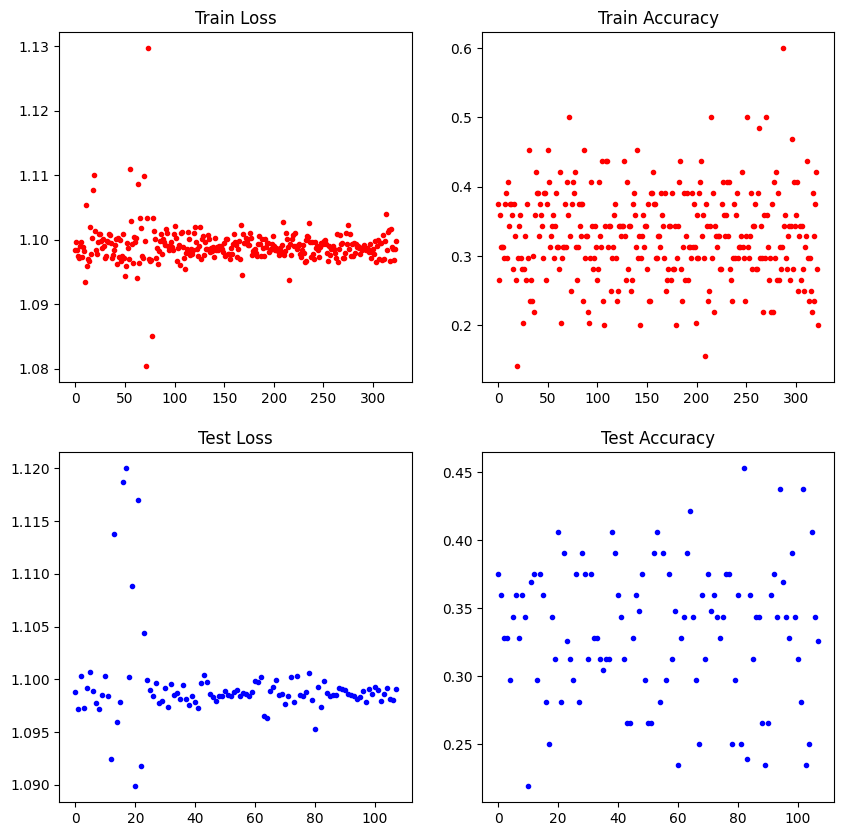

Epoch  9


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Training loss:  0.017582105265723333  train acc:  0.3257777777777778


Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch:  9  test set accuracy:  0.3333333333333333


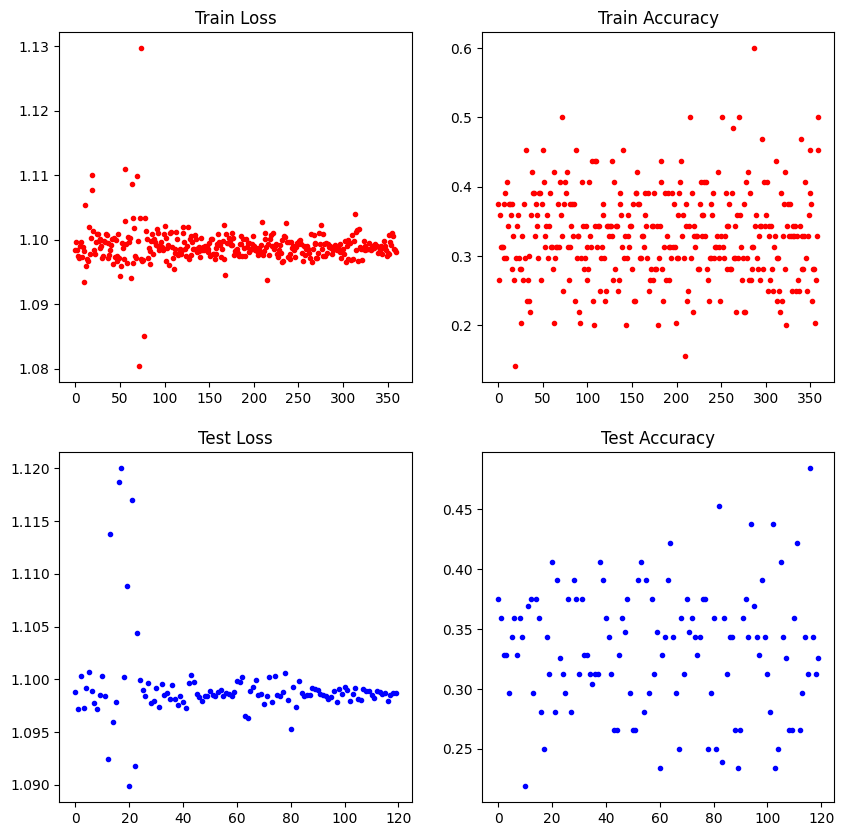

In [18]:
from collections import defaultdict
from IPython.display import clear_output, display
train_results = defaultdict(list)
train_iter, test_iter, best_acc = 0,0,0
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
ax1.set_title('Train Loss')
ax2.set_title('Train Accuracy')
ax3.set_title('Test Loss')
ax4.set_title('Test Accuracy')

for i in tnrange(epochs, desc='Epochs'):
    clear_output(wait=True)
    display(fig)
    print("Epoch ",i)
    ## Train Phase
    #Model switches to train phase
    model.train() 
    
    # Running through all mini batches in the dataset
    count, loss_val, correct, total = train_iter, 0, 0, 0
    for data, target in notebook.tqdm(train_loader, desc='Training'):    
        if use_gpu: #Using GPU & Cuda
            data, target = data.to(device), target.to(device)

        output = model(data) #FWD prop
        loss = criterion(output, target) #Cross entropy loss
        c_loss = loss.data.item()
        ax1.plot(count, c_loss, 'r.')
        loss_val += c_loss

        optimizer.zero_grad() #Zero out any cached gradients
        loss.backward() #Backward pass
        optimizer.step() #Update the weights

        #Compute accuracy
        predicted = output.data.max(1)[1] #get index of max
        total += target.size(0) #total samples in mini batch
        c_acc = (predicted == target).sum().item()
        ax2.plot(count, c_acc/target.size(0), 'r.')
        correct += c_acc
        count +=1
    train_loss_val, train_iter, train_acc = loss_val/len(train_loader.dataset), count, correct/float(total)
    
    print("Training loss: ", train_loss_val, " train acc: ",train_acc)    
    ## Test Phase
    
    #Model switches to test phase
    model.eval()

    #Running through all mini batches in the dataset
    count, correct, total, lost_val = test_iter, 0, 0, 0
    for data, target in notebook.tqdm(test_loader, desc='Testing'):
        if use_gpu: #Using GPU & Cuda
            data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target) #Cross entropy loss
        c_loss = loss.data.item()
        ax3.plot(count, c_loss, 'b.')
        loss_val += c_loss
        #Compute accuracy
        predicted = output.data.max(1)[1] #get index of max
        total += target.size(0) #total samples in mini batch
        c_acc = (predicted == target).sum().item()
        ax4.plot(count, c_acc/target.size(0), 'b.')
        correct += c_acc
        count += 1

    #Accuracy over entire dataset
    test_acc, test_iter, test_loss_val = correct/float(total), count, loss_val/len(test_loader.dataset)
    print("Epoch: ",i," test set accuracy: ",test_acc)
    
    train_results['epoch'].append(i)
    train_results['train_loss'].append(train_loss_val)
    train_results['train_acc'].append(train_acc)
    train_results['train_iter'].append(train_iter)
    
    train_results['test_loss'].append(test_loss_val)
    train_results['test_acc'].append(test_acc)
    train_results['test_iter'].append(test_iter)
    
    #Save model with best accuracy
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth') 
plt.show()
fig.savefig('train.png')

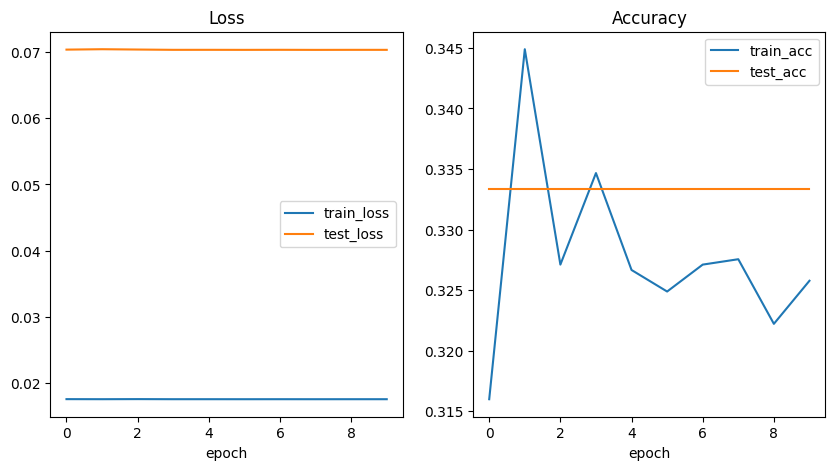

In [19]:
train_results_df = pd.DataFrame(train_results)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
train_results_df.plot('epoch', ['train_loss', 'test_loss'], ax=ax1)
ax1.set_title('Loss')
train_results_df.plot('epoch', ['train_acc', 'test_acc'], ax=ax2)
ax2.set_title('Accuracy')
fig.savefig('epochs.png')